In [1]:
import json
from plotter import TrajectoryPlotter
from trajectory import DataTrajectory
from analyse import MultiTrajectoryAnalyser, SingleTrajectoryAnalyser
from utils.param_key import *

# 1. Define the file names and paths for your data
To run the experiments, the path and filenames of the data has to be set.
The following four parameters are necessary:
1. **trajectory_name** = Name of the trajectory (used for plot titles)
2. **filename_list** = The list of filenames of the trajectories (e.g. .xtc/.dcd- files)
3. **topology_filename**: .pdb-file of the trajectory
4. **folder_path** (e.g. data/protein-name): path to the folder, where the trajectory files are (make sure to have the pdb data and the trajectories in the same folder)


In [2]:
def get_files_and_kwargs(params):
    trajectory_name = params[TRAJECTORY_NAME]
    file_element = params[FILE_ELEMENT]
    if trajectory_name == '2f4k':
        filenames_list = [f'2F4K-0-protein-{i:03d}.dcd' for i in range(0, 62 + 1)] + ['tr3_unfolded.xtc',
                                                                                      'tr8_folded.xtc']
        file_kwargs = {'filename': filenames_list[file_element],
                       'topology_filename': '2f4k.pdb',
                       'folder_path': 'data/2f4k'}
    elif trajectory_name == 'prot2':
        filenames_list = ['prod_r1_nojump_prot.xtc',
                          'prod_r2_nojump_prot.xtc',
                          'prod_r3_nojump_prot.xtc']
        file_kwargs = {'filename': filenames_list[file_element],
                       'topology_filename': 'prod_r1_pbc_fit_prot_last.pdb',
                       'folder_path': 'data/ProtNo2'}
    elif trajectory_name == 'savinase':
        filenames_list = ['savinase_1.xtc', 'savinase_2.xtc']
        file_kwargs = {'filename': filenames_list[file_element],
                       'topology_filename': 'savinase.pdb',
                       'folder_path': 'data/Savinase'}
    elif trajectory_name == '2wav':
        filenames_list = [f'2WAV-0-protein-{i:03d}.dcd' for i in range(0, 136)]
        file_kwargs = {'filename': filenames_list[file_element],
                       'topology_filename': '2wav.pdb',
                       'folder_path': 'data/2WAV-0-protein',
                       'atoms': list(range(710))}
    elif trajectory_name == '5i6x':
        filenames_list = ['protein.xtc', 'system.xtc']
        file_kwargs = {'filename': filenames_list[file_element],
                       'topology_filename': '5i6x.pdb',
                       'folder_path': 'data/ser-tr'}
    elif trajectory_name == 'fs-peptide':
        filenames_list = [f'trajectory-{i}.xtc' for i in range(1, 28 + 1)]
        file_kwargs = {'filename': filenames_list[file_element], 'topology_filename': 'fs-peptide.pdb',
                       'folder_path': 'data/fs-peptide'}
    else:
        raise ValueError(f'No data trajectory was found with the name `{trajectory_name}`.')
    file_kwargs['params'] = params
    filenames_list.pop(file_element)
    return filenames_list, file_kwargs

# Initialize Model Parameters
To run the program, models with different parameters can be used and trained.
In this cell, the different parameters of the models can be set.
Although, it's **recommended using a .json file** instead and load the parameters.
In this cell the different parameters are explained, this includes important and optional parameters.

### Algorithms
In the following some main algorithms with its parameter settings are listed:
1. PCA
    - `{ALGORITHM_NAME: 'original_pca', NDIM: MATRIX_NDIM}` or
    - `{ALGORITHM_NAME: 'pca', NDIM: TENSOR_NDIM, USE_STD: False, ABS_EVAL_SORT: False}`
2. TICA
    - `{ALGORITHM_NAME: 'original_tica', NDIM: MATRIX_NDIM}` or
    - `{ALGORITHM_NAME: 'tica', LAG_TIME: params[LAG_TIME], NDIM: MATRIX_NDIM, USE_STD: False, ABS_EVAL_SORT: False}`
3. raw MATRIX models
    - `{ALGORITHM_NAME: 'pca', NDIM: MATRIX_NDIM}`
    - `{ALGORITHM_NAME: 'tica', NDIM: MATRIX_NDIM, LAG_TIME: params[LAG_TIME]}`

4. raw TENSOR models
    - `{ALGORITHM_NAME: 'pca', NDIM: TENSOR_NDIM}`
    - `{ALGORITHM_NAME: 'tica', NDIM: TENSOR_NDIM, LAG_TIME: params[LAG_TIME]}`

## Parameters
### Important Parameters
1. ALGORITHM_NAME:
    - 'pca'
    - 'tica'
    - ('original_pca')
    - ('original_tica')
2. NDIM:
    - MATRIX_NDIM (=2)
    - TENSOR_NDIM (=3)

### Optional Parameters
The different parameters and their different options are listed here below.
1. KERNEL
    - KERNEL_ONLY
    - KERNEL_DIFFERENCE
    - KERNEL_MULTIPLICATION
2. KERNEL_TYPE
    - MY_GAUSSIAN
    - MY_EXPONENTIAL
    - MY_LINEAR
    - MY_EPANECHNIKOV
    - GAUSSIAN, EXPONENTIAL, LINEAR, EPANECHNIKOV (only with interval 1 fitting)
3. COV_FUNCTION
    - np.cov
    - np.corrcoef
    - utils.matrix_tools.co_mad
4. NTH_EIGENVECTOR (int)
5. LAG_TIME (int)

### Boolean Parameters
1. CORR_KERNEL
2. ONES_ON_KERNEL_DIAG
3. USE_STD
4. CENTER_OVER_TIME
5. EXTRA_DR_LAYER

In [3]:
def get_model_params_list(alg_json_file, params):
    if alg_json_file is not None:
        return json.load(open(alg_json_file))
        # return json.load(open('algorithm_parameters_list.json'))
    else:
        return [
            # Original Algorithms
            {ALGORITHM_NAME: 'original_pca', NDIM: MATRIX_NDIM},
            {ALGORITHM_NAME: 'original_tica', NDIM: MATRIX_NDIM},
            # Insert your model parameters
            {ALGORITHM_NAME: 'pca', NDIM: TENSOR_NDIM, KERNEL: KERNEL_ONLY, ANALYSE_PLOT_TYPE: PLOT_3D_MAP},
        ]

# Define the parameter grid, for a model grid search

In [5]:
def get_param_grid():
    return [
        {
            ALGORITHM_NAME: ['pca', 'tica'],
            KERNEL: [None],
        }, {
            ALGORITHM_NAME: ['pca', 'tica', 'kica'],
            LAG_TIME: [10],
            KERNEL: [KERNEL_DIFFERENCE, KERNEL_MULTIPLICATION, KERNEL_ONLY],
            KERNEL_TYPE: [MY_LINEAR, MY_GAUSSIAN, MY_EXPONENTIAL, MY_EPANECHNIKOV],
            ONES_ON_KERNEL_DIAG: [True, False],
            # EXTRA_DR_LAYER: [False, True],
            # EXTRA_LAYER_ON_PROJECTION: [False, True],
            ABS_EVAL_SORT: [False, True]
        }
    ]

# Define parameters for different runs

In [6]:
run_params_json = None  # NotYetImplemented
alg_params_json = 'config_files/algorithm/algorithm_parameters_list.json'
run_params = {
    PLOT_TYPE: COLOR_MAP,  # 'heat_map', 'color_map', '3d_map', 'explained_var_plot'
    PLOT_TICS: True,  # True, False
    STANDARDIZED_PLOT: False,  # True, False
    CARBON_ATOMS_ONLY: True,  # True, False
    INTERACTIVE: True,  # True, False
    N_COMPONENTS: None,
    LAG_TIME: 10,
    TRUNCATION_VALUE: 0,  # deprecated
    BASIS_TRANSFORMATION: False,
    USE_ANGLES: False,
    TRAJECTORY_NAME: '2f4k',
    FILE_ELEMENT: 0,
}

filename_list, kwargs = get_files_and_kwargs(run_params)
model_params_list = get_model_params_list(alg_params_json, run_params)
param_grid = get_param_grid()

# Plot the Molecules with a Slider to choose the time-stem of the plotting

In [ ]:
tr = DataTrajectory(**kwargs)
TrajectoryPlotter(tr).data_with_timestep_slider(min_max=None)

# Compare models (Qualitative)
Plots the different models side by side, demonstrating the reduced dimensions
NOTE: qualitative plot works only for 2 components

In [ ]:
if run_params[N_COMPONENTS] != 2:
    raise ValueError("Qualitative plot only works for 2 Components")
else:
    tr = DataTrajectory(**kwargs)
    SingleTrajectoryAnalyser(tr).compare(model_params_list)

# Analyse Multiple trajectories

In [7]:
kwargs_list = [kwargs]
for filename in filename_list:
    new_kwargs = kwargs.copy()
    new_kwargs['filename'] = filename
    kwargs_list.append(new_kwargs)

## Compare Kernels

Loading trajectory 2F4K-0-protein-000.dcd...


C:\Users\poliv\.conda\envs\tSNEpy\lib\site-packages\mdtraj\formats\pdb\pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (ATOM      9  N   SER X   1      21.350  12.200  22.900  1.00  0.00      SYST    , ATOM      8  O   LEU X   1      20.450  10.170  22.620  1.00  0.00      SYST    )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))
C:\Users\poliv\.conda\envs\tSNEpy\lib\site-packages\mdtraj\formats\pdb\pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (ATOM     15  N   ASP X   1      19.120  15.080  23.360  1.00  0.00      SYST    , ATOM     14  OG  SER X   1      21.420  13.550  25.410  1.00  0.00      SYST    )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))
C:\Users\poliv\.conda\envs\tSNEpy\lib\site-packages\mdtraj\formats\pdb\pdbstructure.py:435: UserWarning: WARNING: tw

Trajectory `<mdtraj.Trajectory with 10000 frames, 577 atoms, 68 residues, and unitcells>` successfully loaded.
Loading trajectory 2F4K-0-protein-001.dcd...
Trajectory `<mdtraj.Trajectory with 10000 frames, 577 atoms, 68 residues, and unitcells>` successfully loaded.
Loading trajectory 2F4K-0-protein-002.dcd...
Trajectory `<mdtraj.Trajectory with 10000 frames, 577 atoms, 68 residues, and unitcells>` successfully loaded.
Loading trajectory 2F4K-0-protein-003.dcd...
Trajectory `<mdtraj.Trajectory with 10000 frames, 577 atoms, 68 residues, and unitcells>` successfully loaded.
Loading trajectory 2F4K-0-protein-004.dcd...
Trajectory `<mdtraj.Trajectory with 10000 frames, 577 atoms, 68 residues, and unitcells>` successfully loaded.
Loading trajectory 2F4K-0-protein-005.dcd...
Trajectory `<mdtraj.Trajectory with 10000 frames, 577 atoms, 68 residues, and unitcells>` successfully loaded.
Loading trajectory 2F4K-0-protein-006.dcd...
Trajectory `<mdtraj.Trajectory with 10000 frames, 577 atoms, 68 

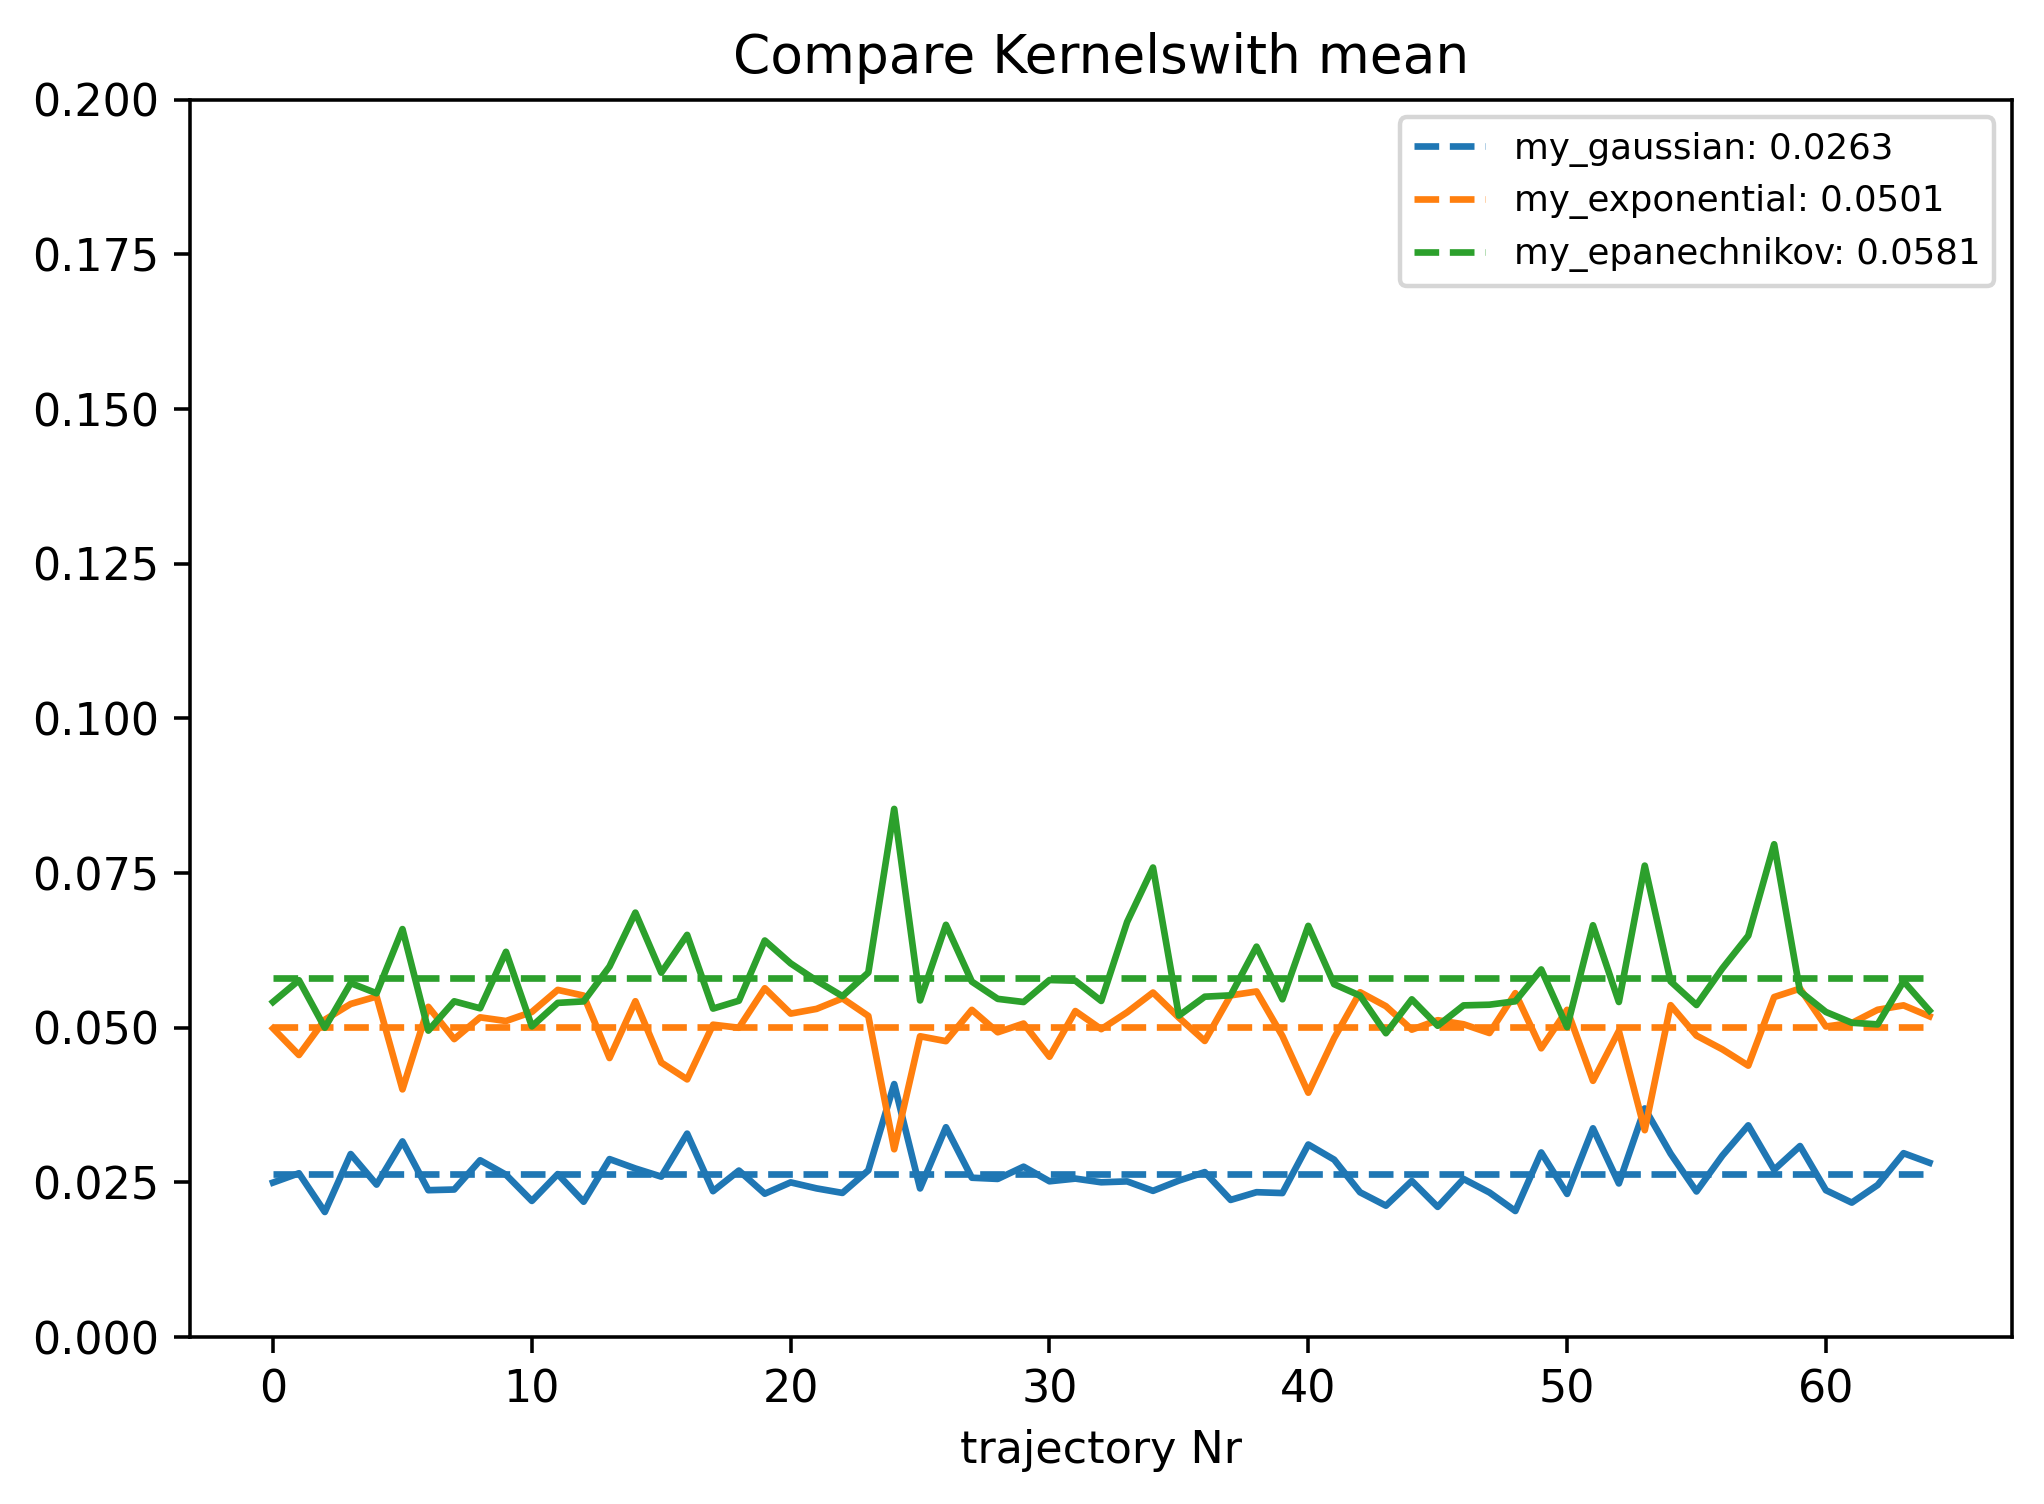

In [8]:
kernel_names = [MY_GAUSSIAN, MY_EXPONENTIAL, MY_EPANECHNIKOV]
model_params_alg_name_only = {ALGORITHM_NAME: 'pca', NDIM: TENSOR_NDIM, ANALYSE_PLOT_TYPE: KERNEL_COMPARE}
mtr = MultiTrajectoryAnalyser(kwargs_list, run_params)
mtr.compare_kernel_fitting_scores(kernel_names, model_params_alg_name_only)